In [42]:
from statistics import mean
from tkinter import Y
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr

In [43]:
data = pd.read_csv("Granite1.csv")
data = data.iloc[2:102]
data.index = np.arange(0, len(data))

X = data[[" X", " Y", " Hardness(GPa)", " Modulus"]]
tempdf = X.copy()
print(tempdf)

           X         Y   Hardness(GPa)      Modulus
0  -3.770873  0.002520        0.387642     6.648113
1  -2.771181  0.002699        1.224675    32.848149
2  -1.771469  0.002709      156.045745  1888.860122
3  -0.771161  0.002709        1.841265    37.080645
4   0.228789  0.002699       10.465644   178.110457
..       ...       ...             ...          ...
95  1.228045 -8.997162       25.739224   211.007222
96  2.227500 -8.997162       42.664982   681.374523
97  3.227748 -8.997162       63.865255   362.929557
98  4.227718 -8.997162       26.693745   185.871818
99  5.228601 -8.997162       17.025402   109.235284

[100 rows x 4 columns]


Extracting Outliers

In [44]:
iqr_multiplier_hard = 1.5 * iqr(X[" Hardness(GPa)"])
third_quar_hard = np.percentile(X[" Hardness(GPa)"], 75)
first_quar_hard = np.percentile(X[" Hardness(GPa)"], 25)
iqr_multiplier_mod = 1.5 * iqr(X[" Modulus"])
third_quar_mod = np.percentile(X[" Modulus"], 75)
first_quar_mod = np.percentile(X[" Modulus"], 25)

outliers = pd.DataFrame(columns=["X","Y","Hardness","Modulus","Index"])

for x in range(len(X[" Hardness(GPa)"])):
    if tempdf[" Hardness(GPa)"][x] > (iqr_multiplier_hard + third_quar_hard) or tempdf[" Hardness(GPa)"][x] < (first_quar_hard - iqr_multiplier_hard):
        outliers.loc[len(outliers.index)] = [float(X[" X"][x]), float(X[" Y"][x]), float(X[" Hardness(GPa)"][x]), float(X[" Modulus"][x]),x]
        tempdf.drop(index=x, inplace=True,axis=0)
    else:
        if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):
            tempdf.drop(index=x,inplace=True)
            outliers.loc[len(outliers.index)] = [X[" X"][x], X[" Y"][x], X[" Hardness(GPa)"][x], X[" Modulus"][x], x]

print(tempdf)

           X         Y   Hardness(GPa)     Modulus
0  -3.770873  0.002520        0.387642    6.648113
1  -2.771181  0.002699        1.224675   32.848149
3  -0.771161  0.002709        1.841265   37.080645
4   0.228789  0.002699       10.465644  178.110457
5   1.228422  0.002709       10.717692  152.847731
..       ...       ...             ...         ...
93 -0.772362 -8.997162        1.558437   36.868433
94  0.228115 -8.997162        3.924556   50.236115
95  1.228045 -8.997162       25.739224  211.007222
98  4.227718 -8.997162       26.693745  185.871818
99  5.228601 -8.997162       17.025402  109.235284

[91 rows x 4 columns]


Interpolate Outliers

In [45]:
for i in range(len(outliers)):
    hard_new = outliers["Hardness"][i]
    mod_new = outliers["Modulus"][i]
    if outliers["Hardness"][i] > (iqr_multiplier_hard + third_quar_hard) or outliers["Hardness"][i] < (first_quar_hard - iqr_multiplier_hard):
        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]
        hard_interp = interpolate.interp1d(o_l[" X"], o_l[" Hardness(GPa)"], kind="linear", fill_value="extrapolate")
        hard_new = hard_interp(outliers["X"][i])
    if outliers["Modulus"][i] > (iqr_multiplier_mod + third_quar_mod) or outliers["Modulus"][i] < (first_quar_mod - iqr_multiplier_mod):
        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]
        mod_interp = interpolate.interp1d(o_l[" X"], o_l[" Modulus"], kind="linear", fill_value="extrapolate")
        mod_new = mod_interp(outliers["X"][i])
    tempdf.loc[outliers["Index"][i]] = [outliers["X"][i], outliers["Y"][i], hard_new, mod_new]

print(tempdf)

             X         Y       Hardness(GPa)             Modulus
0.0  -3.770873  0.002520            0.387642            6.648113
1.0  -2.771181  0.002699            1.224675           32.848149
3.0  -0.771161  0.002709            1.841265           37.080645
4.0   0.228789  0.002699           10.465644          178.110457
5.0   1.228422  0.002709           10.717692          152.847731
...        ...       ...                 ...                 ...
72.0 -1.771588 -6.996855   7.602633237804616  187.81701844488663
80.0 -3.770764 -7.997073  39.317826574992836          292.182908
88.0  4.227797 -7.997093  1.2663065944321295  39.298832853134776
96.0  2.227500 -8.997162           42.664982   202.6324120797797
97.0  3.227748 -8.997162  34.678254357339085          362.929557

[100 rows x 4 columns]


Data Normalization

In [46]:
max_hard = max(tempdf[" Hardness(GPa)"])
min_hard = min(tempdf[" Hardness(GPa)"])
max_mod =  max(tempdf[" Modulus"])
min_mod = min(tempdf[" Modulus"])
max_x = max(tempdf[" X"])
min_x = min(tempdf[" X"])
max_y = max(tempdf[" Y"])
min_y = min(tempdf[" Y"])

for x in range(len(tempdf)):
    tempdf[" Hardness(GPa)"][x] = (tempdf[" Hardness(GPa)"][x]-min_hard)/(max_hard-min_hard)
    tempdf[" Modulus"][x] = (tempdf[" Modulus"][x]-min_mod)/(max_mod-min_mod)
    tempdf[" Y"][x] = round((tempdf[" Y"][x]-min_y)/(max_y-min_y), 2)
    tempdf[" X"][x] = round((tempdf[" X"][x]-min_x)/(max_x-min_x), 2)

print(tempdf)

         X     Y  Hardness(GPa)   Modulus
0.0   0.00  1.00       0.175843  0.269771
1.0   0.11  1.00       0.189755   0.32347
3.0   0.33  1.00       0.200003  0.332145
4.0   0.44  1.00       0.343341  0.621198
5.0   0.56  1.00       0.347531   0.56942
...    ...   ...            ...       ...
72.0  0.22  0.22       0.295758  0.641092
80.0  0.00  0.11        0.82287  0.854999
88.0  0.89  0.11       0.190447  0.336692
96.0  0.67  0.00       0.878501  0.671457
97.0  0.78  0.00        0.74576       1.0

[100 rows x 4 columns]


/var/folders/9g/pn4nc72540zbw3dkklz1ddl00000gn/T/ipykernel_34768/1470082752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf[" Hardness(GPa)"][x] = (tempdf[" Hardness(GPa)"][x]-min_hard)/(max_hard-min_hard)
/var/folders/9g/pn4nc72540zbw3dkklz1ddl00000gn/T/ipykernel_34768/1470082752.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf[" Modulus"][x] = (tempdf[" Modulus"][x]-min_mod)/(max_mod-min_mod)
/var/folders/9g/pn4nc72540zbw3dkklz1ddl00000gn/T/ipykernel_34768/1470082752.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

Add Data Points

In [47]:
tempdf = tempdf.sort_index()
print(tempdf)

x = np.linspace(0, 1, 10)
y = np.linspace(1, 0, 10)
xx,yy = np.meshgrid(x,y)
z_h = tempdf[" Hardness(GPa)"].to_numpy().reshape([10,10])
z_m = tempdf[" Modulus"].to_numpy().reshape([10,10])

hard_interp_norm=interpolate.interp2d(x, y, z_h, kind="linear")
mod_interp_norm=interpolate.interp2d(x, y, z_m, kind="linear")

         X    Y  Hardness(GPa)   Modulus
0.0   0.00  1.0       0.175843  0.269771
1.0   0.11  1.0       0.189755   0.32347
2.0   0.22  1.0       0.194877  0.327806
3.0   0.33  1.0       0.200003  0.332145
4.0   0.44  1.0       0.343341  0.621198
...    ...  ...            ...       ...
95.0  0.56  0.0       0.597191  0.688622
96.0  0.67  0.0       0.878501  0.671457
97.0  0.78  0.0        0.74576       1.0
98.0  0.89  0.0       0.613056  0.637105
99.0  1.00  0.0       0.452366  0.480032

[100 rows x 4 columns]


In [48]:
new_temp = pd.DataFrame()
pts = 20
feature_x = np.linspace(0, 1, pts)
feature_y = np.linspace(1, 0, pts)

new_temp["X"] = list(feature_x) * pts
arr = []
for i in list(feature_y):
    arr.append([i]*pts)
new_temp["Y"] = np.array(arr).reshape([pts*pts, 1])

feature_hard = hard_interp_norm(feature_x, feature_y).reshape([pts*pts,1])
feature_mod = mod_interp_norm(feature_x, feature_y).reshape([pts*pts,1])
feature_hard = [i[0] for i in feature_hard]
feature_mod = [i[0] for i in feature_mod]

#weights of x and y
new_temp["X"] = 0.1 * new_temp["X"]
new_temp["Y"] = 0.1 * new_temp["Y"]
new_temp["Hardness"] = feature_hard
new_temp["Modulus"] = feature_mod

new_temp.head()
new_temp.to_csv("G1.csv")

K-Means Clustering

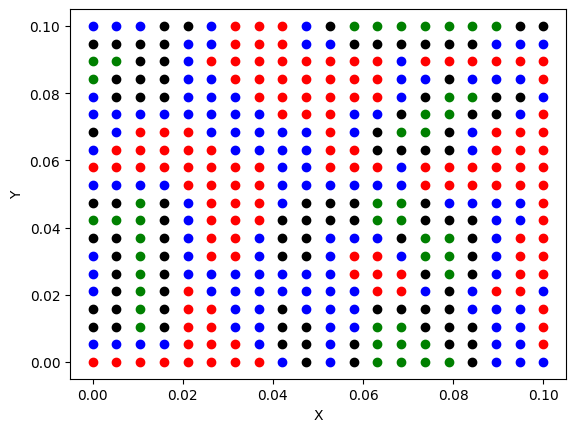

In [49]:
km = KMeans(n_clusters = 4, init="k-means++",max_iter=300,n_init=10,random_state=0)
km.fit(new_temp)
clusters = km.predict(new_temp)
new_temp["Cluster"]=clusters

color=["blue", "green", "red", "black"]

for i in range(len(new_temp)):
    plt.scatter(new_temp["X"][i], new_temp["Y"][i], c = color[new_temp["Cluster"][i]])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Contour Map

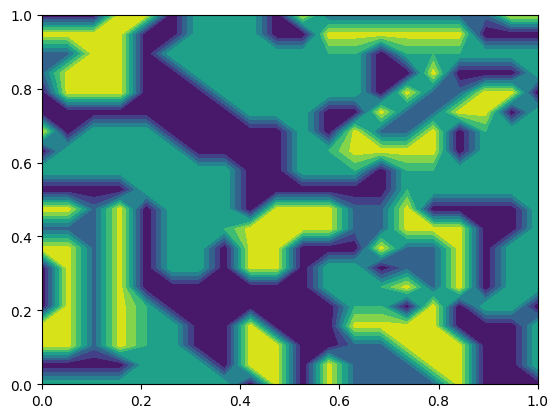

In [50]:
z_cluster = new_temp["Cluster"].to_numpy().reshape([pts,pts])

fig,ax = plt.subplots(1,1)
ax.contourf(feature_x, feature_y, z_cluster)
plt.show()